# Comparing Binomial Proportion and Sample Size Calculations for Wilson Score and Clopper-Pearson Exact Tests

This notebook describes how to compute sample sizes do determine binomial proportion $p$ to attain a specified power using two different hypothesis testing methods.  It follows [Krishnamoorthy & Peng 2007](https://www.tandfonline.com/doi/abs/10.1080/03610910701569218) (KP07).  Related information can be found on the [Wikipedia page for the same problem](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Tests

Let $X$ be a binomial $(n, p)$ RV with PMF of

$$
f(x|n, p) = {n \choose x}p^x(1-p)^{(n-x)},\,\, x=0, 1,...n
$$

### The Wilson Score Test

Approximating the binomial RV with a normal RV $\mathcal{N}(np, np(1-p))$, we can calculate its [standard score](https://en.wikipedia.org/wiki/Z-test), or z-score, using

$$
Z(X, n, p_0) = \frac{X - np_0}{\sqrt{n p_0(1 - p_0)}}
$$

For a one sided test, i.e.

\begin{eqnarray}
H_0: p \leq p_0\\
H_\alpha: p > p_0
\end{eqnarray}

we can reject or fail to reject $H_0$ at some confidence level when

$$
|Z(X, n, p_0)| \geq z_\mathrm{\alpha}
$$

For a two-sided test,

\begin{eqnarray}
H_0: p = p_0\\
H_\alpha: p \neq p_0
\end{eqnarray}

we can reject or fail to reject $H_0$ at some confidence level when

$$
|Z(X, n, p_0)| \geq z_\mathrm{\alpha / 2}
$$

where $z_\mathrm{\alpha / 2}$ is the upper $\alpha/2$ quantile of the standard normal (eg. $z = 1.96$ for 95% confidence).

It's recommended by [Brown et al. 2001](https://projecteuclid.org/euclid.ss/1009213286) and some government agencies (eg. [Washington Department of Health](https://www.doh.wa.gov/Portals/1/Documents/1500/ConfIntGuide.pdf)) because alternatives are overly conservative.

### The Clopper-Pearson Exact Test

Instead of using the normal approximation, we can perform the same test as above using the exact values of the (discrete) CMF:

$$
P(X \geq k|n, p_0) = \sum_{i=k}^n{n\choose i}p_0^i(1-p_0)^{n-1}
$$

If we wanted to test the one-sided hypothesis to some confidence level $\alpha$, we would just need to check whether $P(X \geq k|n, p_0) \leq \alpha$.  For a two-sided test, we'd use

$$
min(P(X \leq k|n, p_0), P(X \geq k|n, p_0)) \leq \frac{\alpha}{2}
$$

*There are imprecisions with the exact test as well, since $n$ can only take on integer values.  These imprecisions are what lead to the reduced power of the test when compared with the score test, as we'll see momentarily.*

## Size and Power Properties

The [size](https://en.wikipedia.org/wiki/Size_(statistics)) of a test is the type-I, or false positive, error probability:

$$
\alpha_\mathrm{err} = P(\mathrm{test\,rejects}\,H_0|H_0)
$$

The [power](https://en.wikipedia.org/wiki/Power_(statistics)) of a test is 1 minus the type-II, or false negative, error probability:

$$
\mathrm{power} = 1 - \beta_\mathrm{err} = 1 - P(\mathrm{test\,fails\,to\,reject}\,H_0|H_\alpha) = P(\mathrm{test\,rejects}\,H_0|H_\alpha)
$$

Take $[x]_+$ and $[x]_-$ to denote the smallest integer greater than $x$ and the largest integer smaller than $x$, respectively.

### The Score Test

The power for the one-sided score test, for $X\sim \mathrm{binomial}(n, p)$ and $p > p_0$

$$
1 - \beta_\mathrm{err} = P(Z(X, n, p_0) \geq z_\alpha|n, p) = P(X \geq [np_0 + z_\alpha\sqrt{np_0(1-p_0)}]_+|n, p)
$$

For the false positive rate, the null must be true, so $X\sim \mathrm{binomial}(n, p_0)$, and 

$$
\alpha_\mathrm{err} = P(X \geq [np_0 + z_\alpha\sqrt{np_0(1-p_0)}]_+|n, p_0)
$$

For the two-sided test and $p \neq p_0$, the power is

$$
1 - \beta_\mathrm{err} = P(X \geq [np_0 + z_\alpha\sqrt{np_0(1-p_0)}]_+|n, p) + P(X \leq [np_0 - z_\alpha\sqrt{np_0(1-p_0)}]_+|n, p)
$$

The size can also be obtained by setting $p = p_0$, and is at most $\alpha_\mathrm{err} = \alpha$.

#### A Disagreement with KP07

I'm not entirely happy with how the one-sided hypotheses are defined.  For example, to actually calculate the probability of $H_0$ for the one-sided exact test, we'd need to integrate  $p' \in [0, p_0]$ over all $P(X \geq k|n, p')$.  Assuming a flat prior - $p'$ is equally likely to be anywhere within that interval, the probability would look something like

$$
P(X \geq k|n, [0, p_0]) = \frac{\int_0^{p_0} \sum_{i=k}^n{n\choose i}p' ^i(1-p')^{n-1} dp'}{\int_0^1 \sum_{i=k}^n{n\choose i}p' ^i(1-p')^{n-1} dp'}
$$

Since this is not done, I'd argue what we're actually doing with the one sided test is something like:

\begin{eqnarray}
H_0: p = p_0\\
H_\alpha: p > p_0
\end{eqnarray}

recognizing that we're examining two alternatives that don't account for all possible states of the system, i.e. $p$ must either equal or be larger than $p_0$, ignoring the fact that $p$ could be smaller.

In [2]:
def binom_score_size_power(n, p, p_0, alpha, two_sided=False):
    if two_sided:
        alpha = alpha / 2.
    stdev = stats.norm.ppf(1. - alpha, loc=0, scale=1) * (n * p_0 * (1. - p_0))**0.5
    power = 1. - stats.binom.cdf(int(np.ceil(n * p_0 + stdev)) - 1, n, p)
    size = 1. - stats.binom.cdf(int(np.ceil(n * p_0 + stdev)) - 1, n, p_0)
    if two_sided:
        power += stats.binom.cdf(int(np.floor(n * p_0 - stdev)), n, p)
        size += stats.binom.cdf(int(np.floor(n * p_0 - stdev)), n, p_0)
    return size, power

In [3]:
binom_score_size_power(100, 0.35, 0.3, 0.05, two_sided=False)

(0.05304558578692509, 0.2975510053267738)

In [4]:
binom_score_size_power(100, 0.35, 0.3, 0.05, two_sided=True)

(0.06281025138953818, 0.23181560977217847)

### The Exact Test

The power of the exact one-sided test is

$$
\sum_{k=0}^n{n \choose k}p^k(1-p)^{n-k}I(P(X \geq k | n, p_0) \leq \alpha)
$$

where $I$ is the indicator function (1 if expression is true, 0 otherwise).  In words, this is the probability to get any $k$ such that $P(X \geq k | n, p_0) \leq \alpha$.  As with before, the size is obtained by setting $p = p_0$.  For the two-sided test the power is 

$$
\sum_{k=0}^n{n \choose k}p^k(1-p)^{n-k}I(2\mathrm{min}(P(X \geq k | n, p_0), P(X \leq k | n, p_0)) \leq \alpha)
$$

In [5]:
stats.binom.ppf(0.05, 10, 0.5)

2.0

In [6]:
stats.binom.cdf(5, 10, 0.5)

0.6230468749999999

In [7]:
def binom_exact_size_power(n, p, p_0, alpha, two_sided=False):
    if two_sided:
        alpha = alpha / 2.

    # Smallest k value that satisfies right side alpha inequality for p_0.
    # binom.ppf returns the first k for which the CDF is larger than 1 - alpha;
    # equivalently k is smallest value such that
    # \sum_{k'=k + 1}^n p(k') <= alpha
    smallest_k_pos = int(stats.binom.ppf(1. - alpha, n, p_0))
    
    power = 1. - stats.binom.cdf(smallest_k_pos, n, p)
    size = 1. - stats.binom.cdf(smallest_k_pos, n, p_0)
    
    if two_sided:
        # Largest k value that satisfies left side alpha inequality for p_0.
        # I.e. k is the largest value such that
        # \sum_{k'=0}^{k-1} p(k') <= alpha
        largest_k_neg = stats.binom.ppf(alpha, n, p_0) - 1
        power += stats.binom.cdf(largest_k_neg, n, p)
        size += stats.binom.cdf(largest_k_neg, n, p_0)

    return size, power

In [8]:
def make_power_size_plot(p=0.35, p_0=0.3, alpha=0.05, n=np.arange(20, 120, 1)):

    sizes_score_1 = np.empty(n.shape[0])
    powers_score_1 = np.empty(n.shape[0])
    sizes_score_2 = np.empty(n.shape[0])
    powers_score_2 = np.empty(n.shape[0])
    sizes_ex_1 = np.empty(n.shape[0])
    powers_ex_1 = np.empty(n.shape[0])
    sizes_ex_2 = np.empty(n.shape[0])
    powers_ex_2 = np.empty(n.shape[0])
    for i in range(n.shape[0]):
        sizes_score_1[i], powers_score_1[i] = binom_score_size_power(n[i], p, p_0, alpha, two_sided=False)
        sizes_score_2[i], powers_score_2[i] = binom_score_size_power(n[i], p, p_0, alpha, two_sided=True)
        sizes_ex_1[i], powers_ex_1[i] = binom_exact_size_power(n[i], p, p_0, alpha, two_sided=False)
        sizes_ex_2[i], powers_ex_2[i] = binom_exact_size_power(n[i], p, p_0, alpha, two_sided=True)

    defaultcolours = plt.rcParams['axes.prop_cycle'].by_key()['color']

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 8))
    fig.subplots_adjust(wspace=0.05)
    ax[0].plot(n, sizes_score_1, label='score size', color=defaultcolours[0])
    ax[0].plot(n, sizes_ex_1, label='exact size', color=defaultcolours[1])
    ax[0].plot(n, powers_score_1, label='score power', color=defaultcolours[0], ls='-.')
    ax[0].plot(n, powers_ex_1, label='exact power', color=defaultcolours[1], ls='-.')
    ax[1].plot(n, sizes_score_2, label='score size', color=defaultcolours[0])
    ax[1].plot(n, sizes_ex_2, label='exact size', color=defaultcolours[1])
    ax[1].plot(n, powers_score_2, label='score power', color=defaultcolours[0], ls='-.')
    ax[1].plot(n, powers_ex_2, label='exact power', color=defaultcolours[1], ls='-.')
    for ax_i in ax:
        ax_i.set_xlabel(r"$n$", fontsize=14)
        ax_i.tick_params(axis='both', which='both', labelsize=12)
        ax_i.axhline(y=0.05, ls='dotted', color='k', lw=1)
    ax[0].set_ylabel('Power, Size', fontsize=14)
    ax[0].legend(loc=2, prop={'size': 12})
    ax[0].set_title("One-Sided")
    ax[1].set_title("Two-Sided")
    
    plt.show()

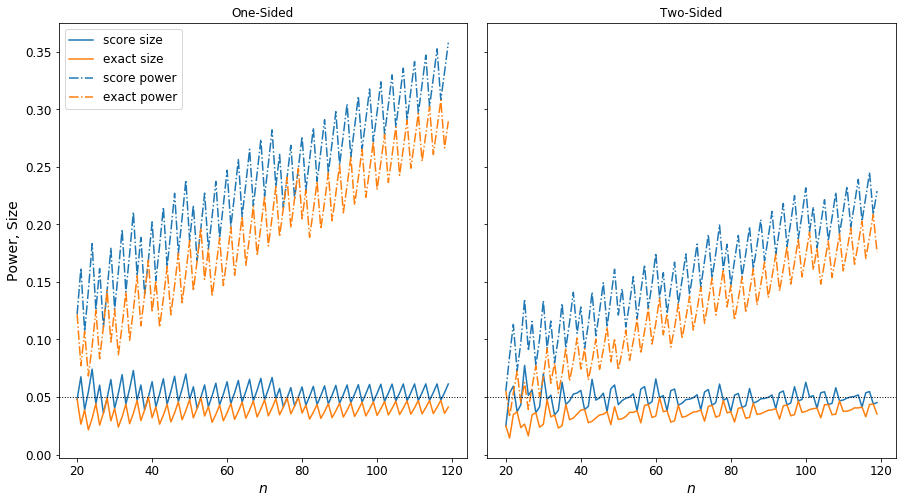

In [9]:
make_power_size_plot()

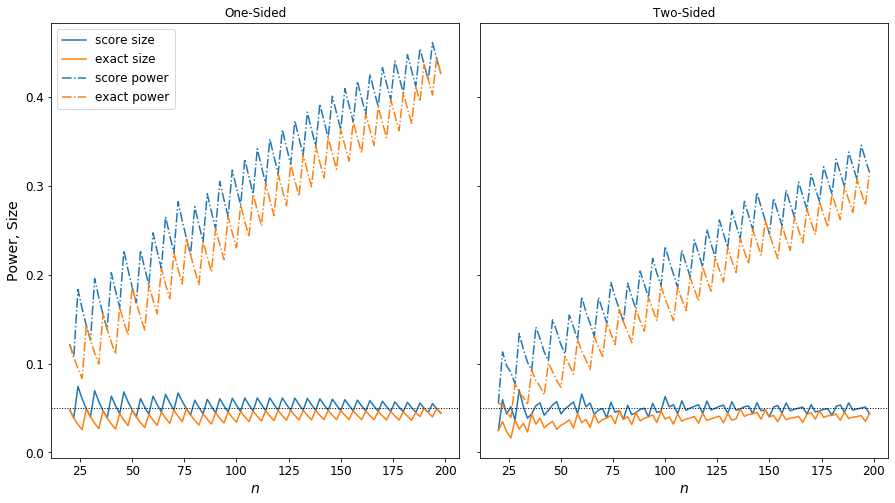

In [10]:
make_power_size_plot(n=np.arange(20, 200, 2))

So overall, the score power and size are higher than the exact power and size.  The exact test has a lower false positive rate, but higher false negative one.

Also, the lefthand figure resembles Fig 1a, but not the righthand figure!

We can verify these plots using Monte Carlo (I initially did this to debug my power functions).

In [11]:
def draw_binom(n, p, N):
    """Binomial draws.
    
    Parameters
    ----------
    n : int
        Number of experiments.
    p : float from [0, 1]
        Experiment success probability.
    N : int
        Number of binomial draws.
    """
    return stats.binom.rvs(n, p, size=N)


def score_test(k, n, p_0, alpha, two_sided=False):
    stdev = (n * p_0 * (1. - p_0))**0.5
    if two_sided:
        z_alpha = stats.norm.ppf(1. - alpha / 2., loc=0, scale=1)
        return True if abs((k - n * p_0) / stdev) >= z_alpha else False   
    z_alpha = stats.norm.ppf(1. - alpha, loc=0, scale=1)
    return True if ((k - n * p_0) / stdev) >= z_alpha else False


def exact_test(k, n, p_0, alpha, two_sided=False):
    if two_sided:
        success_param = min(1. - stats.binom.cdf(k - 1, n, p_0), stats.binom.cdf(k, n, p_0))
        return True if (success_param <= (alpha / 2.)) else False
    return True if (1. - stats.binom.cdf(k - 1, n, p_0)) <= alpha else False


def binom_mc_score_size_power(n, p, p_0, alpha, N, two_sided=False):
    results = np.array([score_test(trial, n, p_0, alpha, two_sided=two_sided)
                        for trial in draw_binom(n, p, N)])
    power = results.sum() / results.shape[0]
    results = np.array([score_test(trial, n, p_0, alpha, two_sided=two_sided)
                        for trial in draw_binom(n, p_0, N)])
    size = results.sum() / results.shape[0]
    return size, power


def binom_mc_exact_size_power(n, p, p_0, alpha, N, two_sided=False):
    results = np.array([exact_test(trial, n, p_0, alpha, two_sided=two_sided)
                        for trial in draw_binom(n, p, N)])
    power = results.sum() / results.shape[0]
    results = np.array([exact_test(trial, n, p_0, alpha, two_sided=two_sided)
                        for trial in draw_binom(n, p_0, N)])
    size = results.sum() / results.shape[0]
    return size, power

In [12]:
binom_mc_exact_size_power(50, 0.35, 0.3, 0.05, 1000, two_sided=False)

(0.056, 0.162)

In [13]:
binom_mc_exact_size_power(50, 0.35, 0.3, 0.05, 1000, two_sided=True)

(0.03, 0.071)

In [14]:
binom_mc_score_size_power(50, 0.35, 0.3, 0.05, 1000, two_sided=False)

(0.047, 0.19)

In [15]:
binom_mc_score_size_power(50, 0.35, 0.3, 0.05, 1000, two_sided=True)

(0.044, 0.111)

In [16]:
from tqdm.auto import tqdm

n = np.arange(20, 120, 1)
p = 0.35
p_0 = 0.3
alpha = 0.05
N = 2000

sizes_score_1 = np.empty(n.shape[0])
powers_score_1 = np.empty(n.shape[0])
sizes_score_2 = np.empty(n.shape[0])
powers_score_2 = np.empty(n.shape[0])
sizes_mcscore_1 = np.empty(n.shape[0])
powers_mcscore_1 = np.empty(n.shape[0])
sizes_mcscore_2 = np.empty(n.shape[0])
powers_mcscore_2 = np.empty(n.shape[0])

for i in tqdm(range(n.shape[0])):
    sizes_score_1[i], powers_score_1[i] = binom_score_size_power(n[i], p, p_0, alpha, two_sided=False)
    sizes_score_2[i], powers_score_2[i] = binom_score_size_power(n[i], p, p_0, alpha, two_sided=True)
    sizes_mcscore_1[i], powers_mcscore_1[i] = binom_mc_score_size_power(
        n[i], p, p_0, alpha, N, two_sided=False)
    sizes_mcscore_2[i], powers_mcscore_2[i] = binom_mc_score_size_power(
        n[i], p, p_0, alpha, N, two_sided=True)

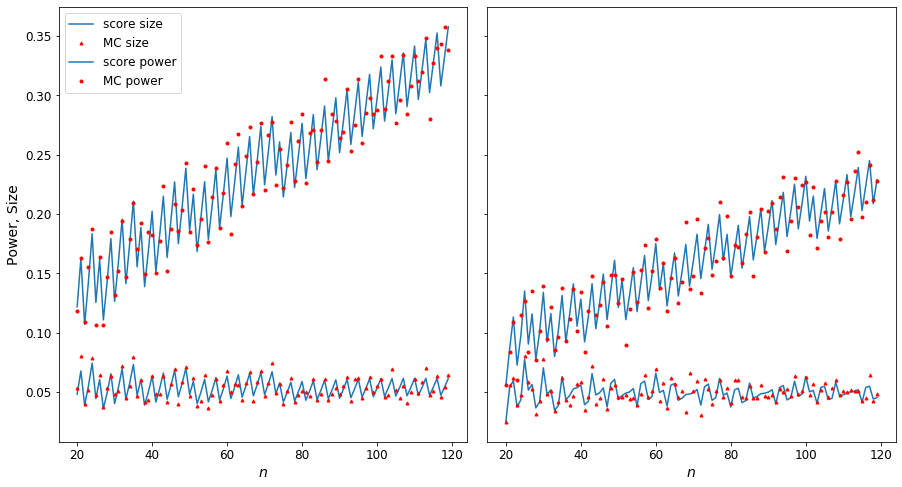

In [18]:
defaultcolours = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 8))
fig.subplots_adjust(wspace=0.05)
ax[0].plot(n, sizes_score_1, label='score size', color=defaultcolours[0])
ax[0].plot(n, sizes_mcscore_1, label='MC size', color='r', ls='None', marker='^', ms=3)
ax[0].plot(n, powers_score_1, label='score power', color=defaultcolours[0])
ax[0].plot(n, powers_mcscore_1, label='MC power', color='r', ls='None', marker='o', ms=3)
ax[1].plot(n, sizes_score_2, label='score size', color=defaultcolours[0])
ax[1].plot(n, sizes_mcscore_2, label='MC size', color='r', ls='None', marker='^', ms=3)
ax[1].plot(n, powers_score_2, label='score power', color=defaultcolours[0])
ax[1].plot(n, powers_mcscore_2, label='MC power', color='r', ls='None', marker='o', ms=3)
for ax_i in ax:
    ax_i.set_xlabel(r"$n$", fontsize=14)
    ax_i.tick_params(axis='both', which='both', labelsize=12)
ax[0].set_ylabel('Power, Size', fontsize=14)
ax[0].legend(loc=2, prop={'size': 12})

plt.show()

In [19]:
n = np.arange(20, 120, 1)
p = 0.35
p_0 = 0.3
alpha = 0.05
N = 2000

sizes_exact_1 = np.empty(n.shape[0])
powers_exact_1 = np.empty(n.shape[0])
sizes_exact_2 = np.empty(n.shape[0])
powers_exact_2 = np.empty(n.shape[0])
sizes_mcexact_1 = np.empty(n.shape[0])
powers_mcexact_1 = np.empty(n.shape[0])
sizes_mcexact_2 = np.empty(n.shape[0])
powers_mcexact_2 = np.empty(n.shape[0])

for i in tqdm(range(n.shape[0])):
    sizes_exact_1[i], powers_exact_1[i] = binom_exact_size_power(n[i], p, p_0, alpha, two_sided=False)
    sizes_exact_2[i], powers_exact_2[i] = binom_exact_size_power(n[i], p, p_0, alpha, two_sided=True)
    sizes_mcexact_1[i], powers_mcexact_1[i] = binom_mc_exact_size_power(
        n[i], p, p_0, alpha, 1000, two_sided=False)
    sizes_mcexact_2[i], powers_mcexact_2[i] = binom_mc_exact_size_power(
        n[i], p, p_0, alpha, 1000, two_sided=True)

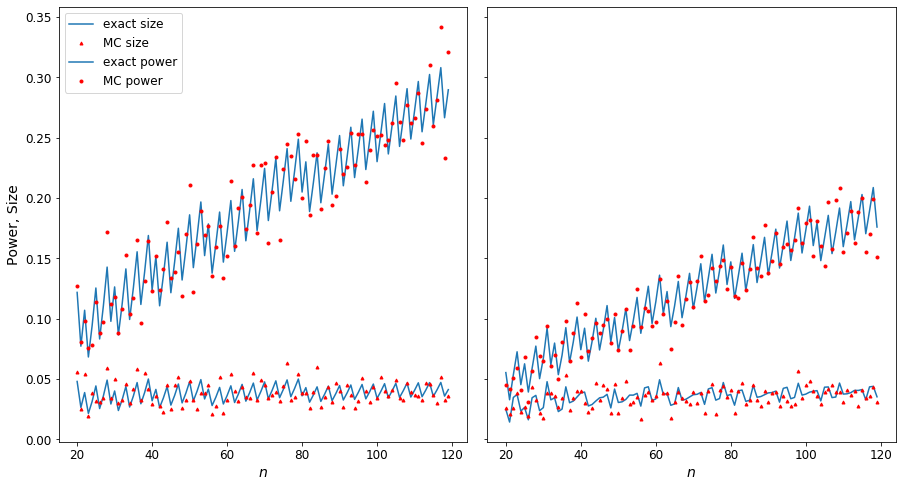

In [20]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 8))
fig.subplots_adjust(wspace=0.05)
ax[0].plot(n, sizes_exact_1, label='exact size', color=defaultcolours[0])
ax[0].plot(n, sizes_mcexact_1, label='MC size', color='r', ls='None', marker='^', ms=3)
ax[0].plot(n, powers_exact_1, label='exact power', color=defaultcolours[0])
ax[0].plot(n, powers_mcexact_1, label='MC power', color='r', ls='None', marker='o', ms=3)
ax[1].plot(n, sizes_exact_2, label='exact size', color=defaultcolours[0])
ax[1].plot(n, sizes_mcexact_2, label='MC size', color='r', ls='None', marker='^', ms=3)
ax[1].plot(n, powers_exact_2, label='exact power', color=defaultcolours[0])
ax[1].plot(n, powers_mcexact_2, label='MC power', color='r', ls='None', marker='o', ms=3)
for ax_i in ax:
    ax_i.set_xlabel(r"$n$", fontsize=14)
    ax_i.tick_params(axis='both', which='both', labelsize=12)
ax[0].set_ylabel('Power, Size', fontsize=14)
ax[0].legend(loc=2, prop={'size': 12})

plt.show()

Pretty sure the power in Fig. 1 in the paper is wrong - the two sided test is more stringent than the
one-sided one, since we divide alpha = 0.05 to 0.025, and test for the probability that the binomial
RV draw is above or below the alpha thresholds.  In the paper, the true p = 0.35, and the null p_0 = 0.3,
so drawing below the lower alpha threshold is highly unlikely compared to drawing above the upper alpha
threshold.  Therefore, the power in the two-sided test should be lower than in the one-sided one, as seen
below and in contrast to Fig. 1.

I also double-checked using the [binom package in R](https://cran.r-project.org/web/packages/binom/binom.pdf), and got the same results.

Regardless, the fluctuations are due to the discretization of the binomial RV.  KP07 note that for the one-sided test, whenever the size is above the nominal $\alpha = 0.05$ level, the score test has more power than the exact test; otherwise they're the same.  For the two-sided test, the score test has a number of values where the size is below $0.05$ while the power is always above the exact test.

## Sample Size

One way to set the sample size is to ensure the power is above some threshold $\gamma_\mathrm{min}$.

### The Score Test

Solve for $n$ within the inequality

$$
P(X \geq [np_0 + z_\alpha\sqrt{np_0(1-p_0)}]_+|n, p) \geq \gamma_\mathrm{min}
$$

Since $P$ fluctuates with $n$, do a forward search starting at small $n$ for the smallest value that satisfies the above.

We can approximate $P$ by assuming that $P \sim \mathcal{N}(np, np(1-p))$.  This yields the approximation

$$
1 - \Phi\left(\frac{np_0 + z_\alpha\sqrt{np_0(1-p_0)} - np}{\sqrt{np(1-p)}}\right)\geq \gamma_\mathrm{min}
$$

where $\Phi$ is the functional form for $\mathcal{N}(0, 1)$.  The smallest $n$ satisfying the above is then

$$
n \approx \frac{\left(z_\gamma\sqrt{p(1-p)} - z_\alpha\sqrt{p_0(1-p_0)} \right)^2}{(p - p_0)^2}
$$

For a two-sided test no analytic approximation exists, but one could replace $z_\alpha$ by $z_{\alpha/2}$.

### The Exact Test

Likewise, solve for $n$ within the inequality

$$
\sum_{k=0}^n{n \choose k}p^k(1-p)^{n-k}I(P(X \geq k | n, p_0) \leq \alpha) \geq \gamma_\mathrm{min}
$$

## Confidence Intervals

Finding the 95% confidence interval of the proportion estimator $\hat{p} = X/n$ can also be done using either the score or exact methods.

### Score Intervals

These are obtained by inverting the score statistic (as we do with the t-test metric to get gaussian confidence intervals), which means solving

$$
\frac{\hat{p} - p}{\sqrt{p(1 - p)/n}} \leq z_{\alpha/2}
$$

for $p$ for two-sided limits; for one-sided ones, use $z_\alpha$ instead.  The score interval is then (also described [here](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval))

$$
\left(\frac{\hat{p} + \frac{z_{\alpha/2}^2}{2n}}{1 + \frac{z_{\alpha/2}^2}{n}}\right) \pm \frac{\frac{z_{\alpha/2}}{\sqrt{n}}\sqrt{\hat{p}(1-\hat{p}) + z_{\alpha/2}^2/(4n)}}{1 + z_{\alpha/2}^2/n}
$$

The half-width of this interval is 

$$
\delta = \frac{\frac{z_{\alpha/2}}{\sqrt{n}}\sqrt{\hat{p}(1-\hat{p}) + z_{\alpha/2}^2/(4n)}}{1 + z_{\alpha/2}^2/n}
$$

which is a random variable (since it contains $\hat{p}$).  The expected length can be calculated by taking $\hat{p} = \hat{x} / n\sim \frac{1}{n}\mathrm{Bin}(n, p)$, then taking the expectation value of $\delta$.  An analytic approximation can be obtained by using the Lemma:

> Let $f(\hat{p})$ be a real-valued function.  Then $E(f(\hat{p})) = f(p) + O(n^{-1})$.

Using this, we get

$$
\delta \approx d = \frac{\frac{z_{\alpha/2}}{\sqrt{n}}\sqrt{p(1-p) + z_{\alpha/2}^2/(4n)}}{1 + z_{\alpha/2}^2/n}
$$

For one-sided test, we can use the same logic as above to get

\begin{eqnarray}
\delta \approx d &=& \left(\frac{p + \frac{z_\alpha^2}{2n}}{1 + \frac{z_\alpha^2}{n}}\right)  + \frac{\frac{z_\alpha}{\sqrt{n}}\sqrt{p(1-p) + z_\alpha^2/(4n)}}{1 + z_\alpha^2/n} - p \\
&=& \frac{z_\alpha^2}{n}\left(\frac{1/2 - p}{1 + \frac{z_\alpha^2}{n}}\right) + \frac{\frac{z_\alpha}{\sqrt{n}}\sqrt{p(1-p) + z_\alpha^2/(4n)}}{1 + z_\alpha^2/n}
\end{eqnarray}

This is corrected from Eqn. 19 of KP07; their sample size equation (Eqn. 20) is correct, however.

### Exact Confidence Intervals

For an observed number of successes $k$, the lower and upper limits of $p$, $p_L$ and $p_U$, respectively, are obtained from:

\begin{eqnarray}
\sum_{i=k}^n {n \choose i} p_L^i(1 - p_L)^{n-i} &=& \alpha / 2 \\
\sum_{i=0}^k {n \choose i} p_U^i(1 - p_U)^{n-i} &=& \alpha / 2
\end{eqnarray}

The [Beta distribution CDF](https://en.wikipedia.org/wiki/Beta_distribution#Probability_density_function) can be to determine $p_L$ and $p_U$:

$$
p_L = B^{-1}(\alpha/2; k, n - k  + 1); p_U = B^{-1}(1 - \alpha/2; k, n - k  + 1)
$$

where $B^{-1}(c; a, b)$ is the $c$th quantile of a beta distribution with shape parameters $a$ and $b$.  The one sided limits are the same as above, except using $\alpha$ instead of $\alpha/2$.

For a given confidence level $1 - \alpha$ and $p$, the expected length of $\delta = p_U - p_L$ is

$$
2\delta = \sum_{i=0}^n {n \choose i} p^i(1 - p)^{n-i} (p_U - p_L)
$$

For the right-side one-sided level, we can use $E(p_U - p)$; for the left-side one, we can use $E(p - p_L)$.

## Sample Sizes for a Specified Precision

### Score Sample Sizes

Using the equations for $d$, we get the following sample size equations for two-sided tests (where $q = 1 - p$)

$$
n \approx \frac{z_{\alpha/2}^2}{2d^2}\left(pq - 2d^2 + \sqrt{(pq - 2d^2)^2 - d^2(4d^2 - 1)}\right)
$$

and one-sided tests

$$
n \approx \frac{z_\alpha^2}{2d^2}\left(pq + d - 2d(p + d) + \sqrt{(pq + d - 2d(p + d))^2 - d^2((2(p + d) - 1)^2 - 1)}\right)
$$

In [21]:
def n_binom_score(p, d, alpha, two_sided=True):
    """Implementation of minimum sample size `n` for one or two-sided score confidence widths `d`."""
    q = 1. - p
    if not two_sided:
        z_alpha = stats.norm.ppf(1. - alpha, loc=0, scale=1)
        sqrt_interior = ((p * q + d - 2. * d * (p + d))**2 -
                         d**2 * ((2. * (p + d) - 1.)**2 - 1.))
        return (z_alpha**2 / 2. / d**2) * (p * q + d - 2. * d * (p + d) + sqrt_interior**0.5)
    z_alpha = stats.norm.ppf(1. - alpha / 2., loc=0, scale=1)
    sqrt_interior = (p * q - 2. * d**2)**2 - d**2 * (4. * d**2 - 1.)
    return (z_alpha**2 / 2. / d**2) * ((p * q - 2. * d**2) + sqrt_interior**0.5)


def d_binom_score(n, p, alpha, two_sided=True):
    """Implementation of score confidence widths `d`.
    
    One-sided test width is from p to `1 - alpha` quantile of score statistic.
    Two-sided test width is one half the `1 - alpha`
    """
    if two_sided:
        alpha /= 2.
    z_alpha = stats.norm.ppf(1. - alpha, loc=0, scale=1)
    q = 1. - p
    second_term = ((z_alpha**2 / n) * (0.5 - p) / (1. + z_alpha**2 / n)
                   if not two_sided else 0.)
    return (z_alpha / n**0.5) * (p * q + z_alpha**2 / 4. / n)**0.5 / (1. + z_alpha**2 / n) + second_term

In [22]:
d_binom_score(n_binom_score(0.72, 0.1, 0.05, two_sided=True), 0.72, 0.05, two_sided=True)

0.10000000000000002

In [23]:
d_binom_score(n_binom_score(0.48, 0.05, 0.05, two_sided=False), 0.48, 0.05, two_sided=False)

0.05000000000000001

In [24]:
n_binom_score(0.72, 0.05, 0.05, two_sided=True)

306.85330598878784

### Exact Sample Sizes

As an approximation to $\sum_{i=0}^n {n \choose i} p^i(1 - p)^{n-i} (p_U - p_L)$, we can use the same lemma as in the score sample size section and treat $E(f(\hat{p})) \approx f(p)$:

$$
2\delta \approx 2d = B^{-1}(1 - \alpha / 2; np + 1, n - np) - B^{-1}(\alpha / 2; np, n - np + 1)
$$

In [25]:
def d_binom_exact_twosided(n, p, alpha):
    return (stats.beta.ppf(1 - alpha / 2., n * p + 1., n - n * p) -
            stats.beta.ppf(alpha / 2., n * p, n - n * p + 1)) / 2.

In [26]:
d_binom_exact_twosided(100, 0.6, 0.05)

0.09974804043739388

In [27]:
d_binom_score(100, 0.6, 0.05, two_sided=True)

0.09429806338823965

For both the score and exact statistics, KP07 note the excellent agreement between the approximate sample sizes derived using the lemma, and sample sizes derived directly from the non-approximated expectation values - as in Table 2, the differences are always in the single-digits, which shouldn't be an issue when $n \sim 1000$.

As for how $d$ from the exact and score statistics differ, we can produce a plot using the approximate $d$ values (given how similar KP07 found $n$ to be, I imagine $d$ shouldn't be too different from $\delta$).  The lefthand plot fixes $n = 40$, and the right-hand plot fixes $p = 0.4$:

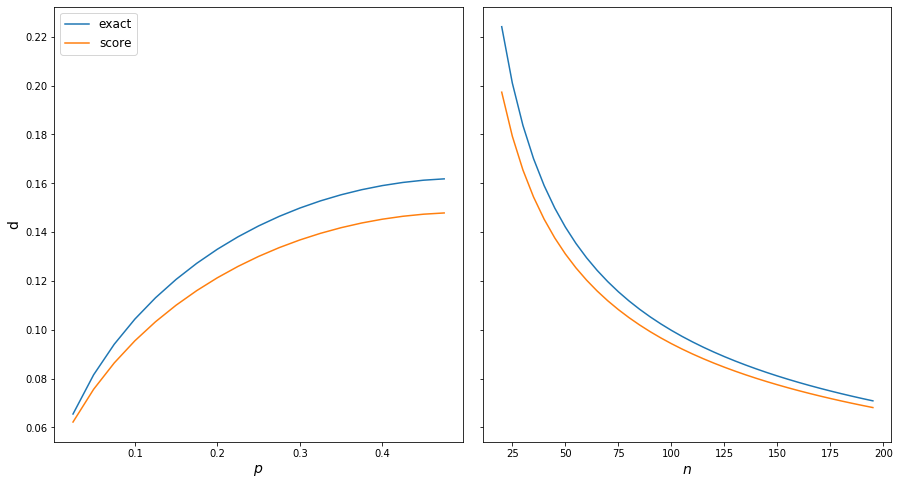

In [28]:
pv = np.arange(0.025, 0.5, 0.025)
n = 40.
alpha = 0.05

d_exact_1 = np.empty(pv.shape[0])
d_score_1 = np.empty(pv.shape[0])
for i in range(len(pv)):
    d_exact_1[i] = d_binom_exact_twosided(n, pv[i], alpha)
    d_score_1[i] = d_binom_score(n, pv[i], alpha, two_sided=True)

nv = np.arange(20, 200, 5)
p = 0.4
    
d_exact_2 = np.empty(nv.shape[0])
d_score_2 = np.empty(nv.shape[0])
for i in range(len(nv)):
    d_exact_2[i] = d_binom_exact_twosided(nv[i], p, alpha)
    d_score_2[i] = d_binom_score(nv[i], p, alpha, two_sided=True)

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 8))
fig.subplots_adjust(wspace=0.05)
ax[0].plot(pv, d_exact_1, label='exact', color=defaultcolours[0])
ax[0].plot(pv, d_score_1, label='score', color=defaultcolours[1])
ax[1].plot(nv, d_exact_2, label='exact', color=defaultcolours[0])
ax[1].plot(nv, d_score_2, label='score', color=defaultcolours[1])
ax[0].set_xlabel(r"$p$", fontsize=14)
ax[1].set_xlabel(r"$n$", fontsize=14)
ax[0].set_ylabel('d', fontsize=14)
ax[0].legend(loc=2, prop={'size': 12})

plt.show()

So for a given set of $n$, $p$ and $\alpha$, the confidence interval for the two-sided score test is narrower.

# Conclusions

- For one-sided tests that control both type I and type II error rates (i.e. maximize power while keeping type-I error rate below some critical value, such as 0.05), either score or exact tests require the same sample size.  (See the power and size plots.)
- For two-sided tests, the score test is recommended since its power is greater and confidence intervals smaller for the same number of samples.